In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['fivethirtyeight'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
figdir = 'figures/mem_key_value'
!mkdir -p $figdir

In [3]:
duration_seconds = 10

results = []
with open('../benchmarks/mem_key_value/aws_c5n.2xlarge_2020_04_14.jsonl', 'rt') as fp:
    for line in fp:
        spec, counts = json.loads(line)
        spec.update(counts)
        results.append(spec)
results = pd.DataFrame(results)
results = results[results['server_threads'].isin([1, 4, 16])]
results = results[results['client_threads'].isin([1, 4, 16])]
results = results[results['seconds'] == duration_seconds].drop('seconds', axis=1)
results['ops'] = results['set'] + results['get']
results['workload'] = results['set_frac'].map({0.1: 'read heavy', 0.5: 'balanced', 0.9: 'write heavy'})
results['keyspace'] = results['key_length'].map({2: 'small', 16: 'large'})
results.head().T

,6,11,21,23,25
server_threads,1,4,16,16,16
client_threads,1,1,1,1,16
map_type,hashtable,hashtable,concurrent,concurrent,hashtable
key_length,16,16,16,16,16
value_length,64,64,64,64,64
set_frac,0.9,0.1,0.9,0.1,0.5
trial_index,2,4,2,6,3
set,75772,17727,78342,17209,90872
get,8462,160384,8659,154572,89892
found,0,0,0,0,0


server_threads  client_threads  count  \
workload    map_type   keyspace                                          
write heavy hashtable  large                1.0             4.0    7.0   
                       small                4.0            16.0    8.0   
            concurrent small               16.0            16.0   10.0   
                       large               16.0            16.0    7.0   
balanced    concurrent small                4.0            16.0    9.0   
                       large               16.0            16.0    9.0   
            hashtable  large               16.0            16.0    7.0   
                       small                4.0            16.0    9.0   
read heavy  hashtable  small                4.0            16.0    6.0   
            concurrent small                4.0            16.0   10.0   
                       large                4.0            16.0    8.0   
            hashtable  large               16.0            16.0    9.0   

                                     min        25%       50%        75%  \
workload    map_type   keyspace                                            
write heavy hashtable  large      9.6252  10.111500  10.29100  10.400100   
                       small      9.8053  10.141650  10.38025  10.746275   
            concurrent small      9.6320  10.016350  10.43080  10.558000   
                       large     10.0043  10.279200  10.46610  10.696550   
balanced    concurrent small     14.0528  15.857400  16.54720  16.661500   
                       large     16.4014  16.493700  16.66760  17.310600   
            hashtable  large     15.5006  16.414600  16.80050  17.697000   
                       small     15.8454  16.437000  16.89670  17.345700   
read heavy  hashtable  small     46.5810  47.099250  48.77875  49.457150   
            concurrent small     46.8809  48.279050  50.05715  51.170550   
                       large     50.1621  51.190975  52.56185  54.391000   
            hashtable  large     50.2172  52.791900  54.02960  54.500100   

                                     max  
workload    map_type   keyspace           
write heavy hashtable  large     10.6387  
                       small     11.2457  
            concurrent small     10.7832  
                       large     10.9617  
balanced    concurrent small     17.4880  
                       large     17.4827  
            hashtable  large     18.0764  
                       small     17.5145  
read heavy  hashtable  small     51.4768  
            concurrent small     51.5247  
                       large     55.0483  
            hashtable  large     55.7172

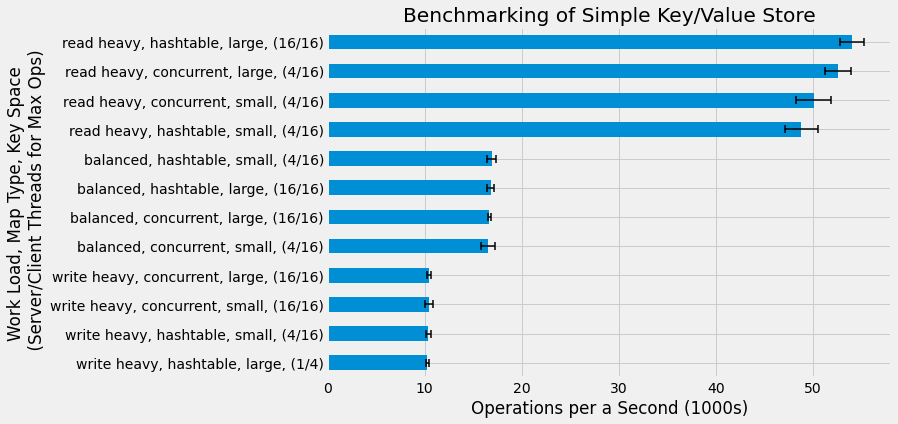

In [4]:
def agg(df):
    agg_ops = df.groupby(['server_threads', 'client_threads'])['ops'].describe()
    idxmax = agg_ops['50%'].idxmax()
    opsmax = agg_ops.T[idxmax]
    s,c = idxmax
    opsmax['server_threads'] = s
    opsmax['client_threads'] = c
    return opsmax
    return pd.Series({'server_threads':s, 'client_threads':c, 'ops': opsmax})
    return median_ops

x = results.copy()
x['ops'] /= duration_seconds
x['ops'] /= 1000
x = x.groupby(['workload', 'map_type', 'keyspace']).apply(agg).sort_values('50%', ascending=True)
iq = x[['25%', '75%']].copy()
iq['25%'] = x['50%'] - iq['25%']
iq['75%'] -= x['50%']
x.plot.barh(figsize=(9, 6), y='50%', xerr=iq.values.T,
            error_kw=dict(ecolor='black', lw=1.5, capsize=4, capthick=1.5))
plt.gca().get_legend().remove()
plt.ylabel('Work Load, Map Type, Key Space\n (Server/Client Threads for Max Ops)')
plt.xlabel('Operations per a Second (1000s)')
plt.title('Benchmarking of Simple Key/Value Store')

def label(ix):
    r = x.T[ix]
    workload, map_type, keyspace = ix
    return f'{workload}, {map_type}, {keyspace}, ({int(r["server_threads"])}/{int(r["client_threads"])})'

plt.gca().set_yticklabels(map(label, x.index))
plt.savefig(figdir + '/benchmarking.png', bbox_inches='tight')
display(x[['server_threads', 'client_threads', 'count', 'min', '25%', '50%', '75%', 'max']])

In [5]:
def analyze_thread_performance(ax, workload, map_type, keyspace):
    x = results.copy()
    x['ops'] /= duration_seconds
    x['ops'] /= 1000
    x = x[(x['workload'] == workload) & (x['map_type'] == map_type) & (x['keyspace'] == keyspace)]
    x = x.groupby(['server_threads', 'client_threads'])['ops'].describe()
    x = x.sort_values('50%')
    iq = x[['25%', '75%']].copy()
    iq['25%'] = x['50%'] - iq['25%']
    iq['75%'] -= x['50%']
    x.plot.barh(ax=ax, y='50%', xerr=iq.values.T,
                error_kw=dict(ecolor='black', lw=1.5, capsize=4, capthick=1.5))
    plt.ylabel('Server Threads, Client Threads')
    plt.xlabel('Operations per a Second (1000s)')
    return x
    #plt.title(f'Benchmarking for {workload}, {map_type}, {keyspace} key space')
    
def analyze_workload_thread_performance(map_type, keyspace, x_max):
    fig = plt.figure(figsize=(9,17))
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'Threading impact for {map_type} map and {keyspace} key space', y=0.93, size=24)
    for i,workload in enumerate(['read heavy', 'balanced', 'write heavy']):
        ax = plt.subplot(3, 1, i+1)
        ax.set_xlim(0, x_max)
        x = analyze_thread_performance(ax, workload, map_type, keyspace)
        m = x['50%']
        rel_diff = (m.max() - m.min()) / m.min()
        ax.set_title(f'{workload} (relative difference of {rel_diff*100:.1f}%)')
    plt.savefig(figdir + f'/threading_{map_type}_{keyspace}.png', bbox_inches='tight')


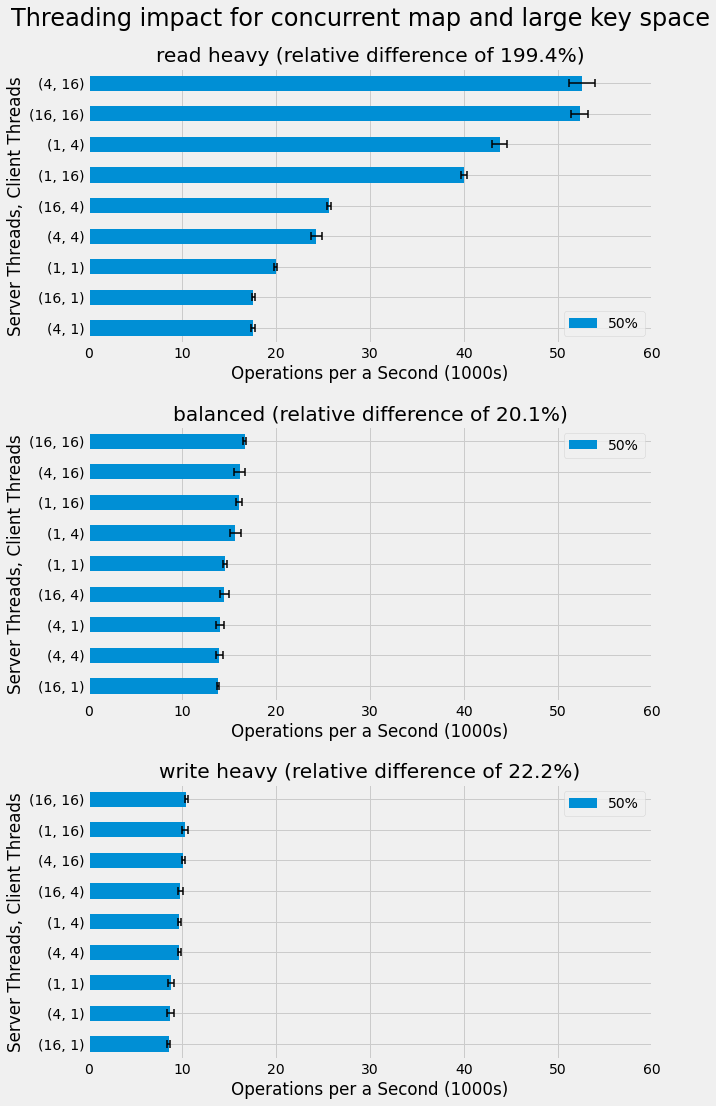

In [6]:
analyze_workload_thread_performance('concurrent', 'large', 60)

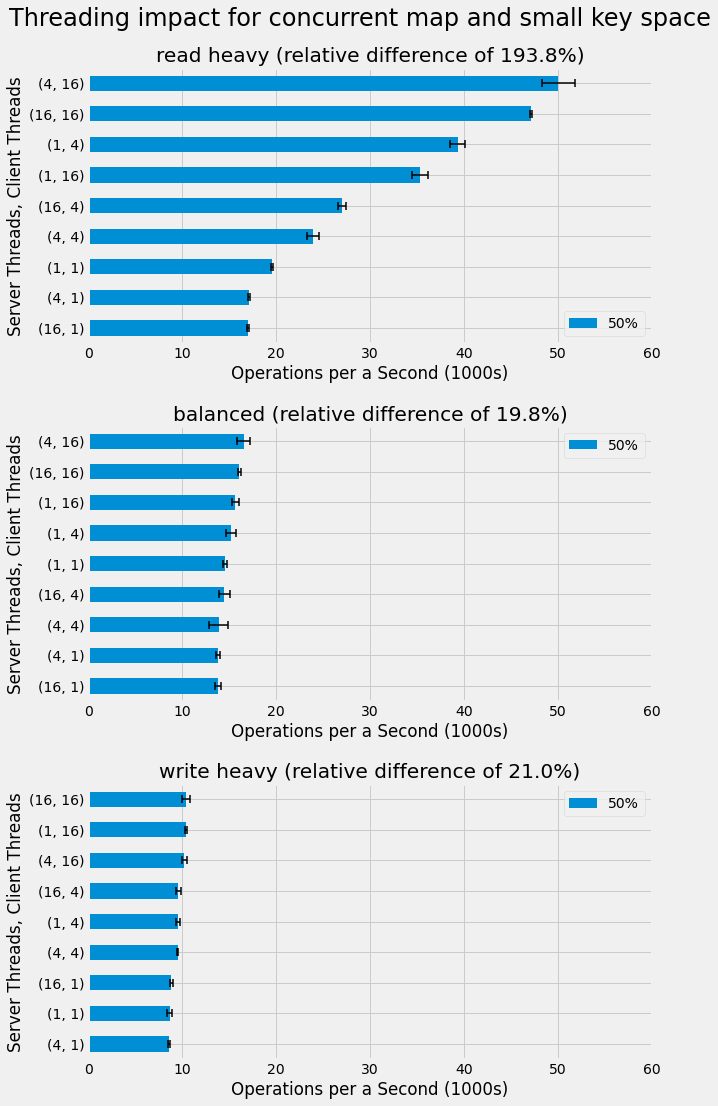

In [7]:
analyze_workload_thread_performance('concurrent', 'small', 60)

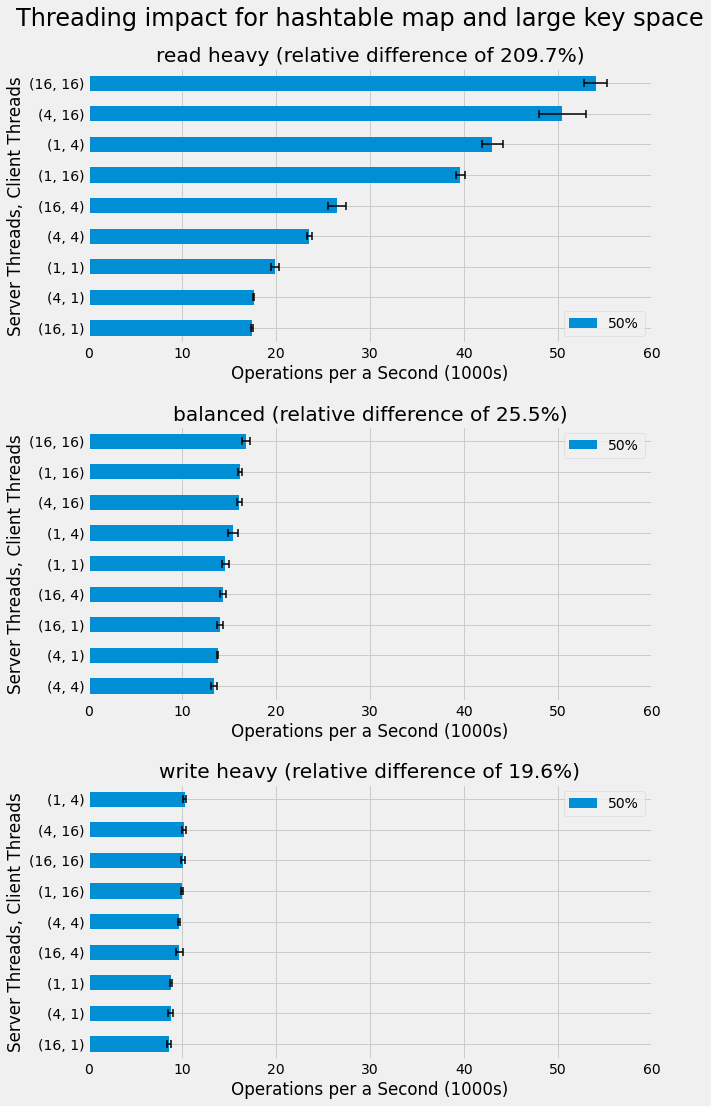

In [8]:
analyze_workload_thread_performance('hashtable', 'large', 60)

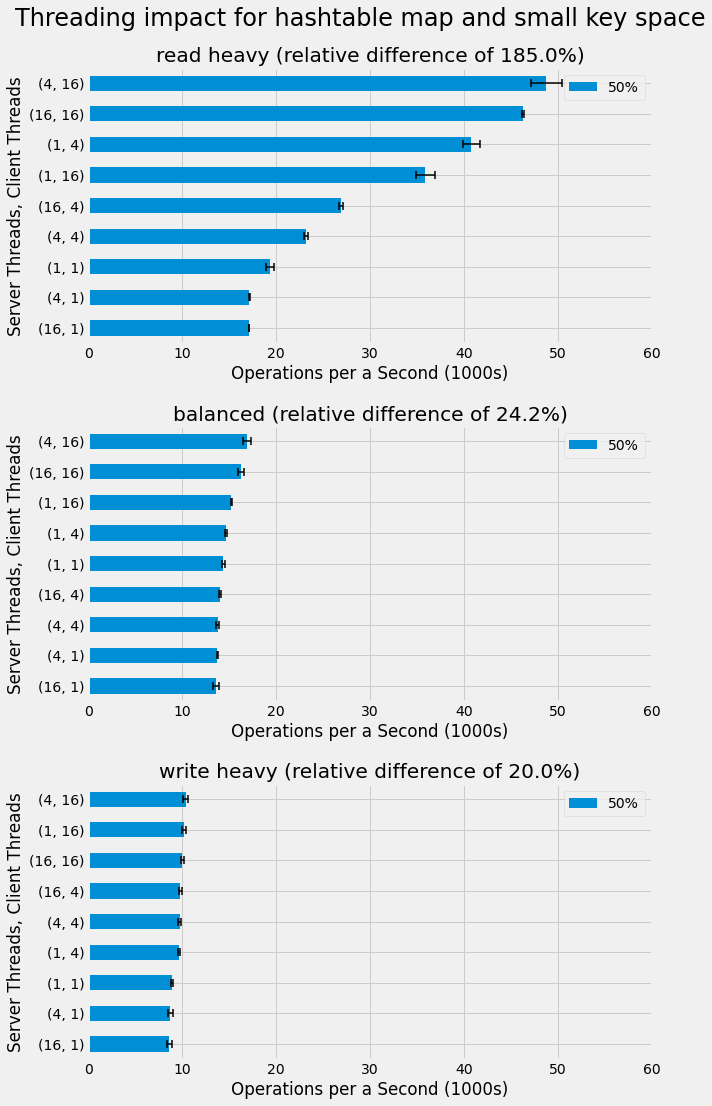

In [9]:
analyze_workload_thread_performance('hashtable', 'small', 60)